In [3]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 200)

Metin ön işleme işlemleri.

In [4]:
df = pd.read_csv("emotion_sentimen_dataset.csv", usecols=["text","Emotion"])
df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [5]:
df.shape

(839555, 2)

In [6]:
# veri çok büyük olduğundan ben sadece ilk 2.000 satırı almak istiyorum

df = df.iloc[:2000, ::]
df.shape


(2000, 2)

In [7]:
# eksik veri kontrolü

df.isnull().sum()


text       0
Emotion    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   Emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [9]:
# hedef sutunundaki benzersiz değerler

df.Emotion.unique()

array(['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness',
       'fun', 'empty', 'enthusiasm', 'sadness', 'surprise'], dtype=object)

In [10]:
# hedef sutunundaki benzersiz değerleri sayısal hale dönüştürme
 

# label encoding
LE = LabelEncoder()
df['Emotion'] = LE.fit_transform(df['Emotion'])
df.head()


,text,Emotion
0,i seriously hate one subject to death but now ...,5
1,im so full of life i feel appalled,7
2,i sit here to write i start to dig out my feel...,7
3,ive been really angry with r and i feel like a...,0
4,i feel suspicious if there is no one outside l...,7


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   Emotion  2000 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 23.6+ KB


In [12]:
df.Emotion.value_counts()

Emotion
7     1665
4       58
6       56
5       48
0       47
8       45
2       24
9       19
11      16
3       13
1        6
10       3
Name: count, dtype: int64

In [13]:
# •	Büyük-küçük harf dönüşümü
# •	Noktalama işaretlerin çıkarılması
# •	Numerik ifadelerin çıkarılması

def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    # Punctuations
    text = text.str.replace(r'[^\w\s]', '')
    text = text.str.replace("\n" , '')
    # Numbers
    text = text.str.replace('\d', '')
    return text

df["text"] = clean_text(df["text"])

df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,5
1,im so full of life i feel appalled,7
2,i sit here to write i start to dig out my feel...,7
3,ive been really angry with r and i feel like a...,0
4,i feel suspicious if there is no one outside l...,7


In [14]:
# Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimelerin çıkarılması

def remove_stopwords(text):
    stop_words = stopwords.words('English')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

df["text"] = remove_stopwords(df["text"])

In [15]:
# Metinde az tekrarlayan kelimeleri bulunuz.

pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]

jades            1
misunderstood    1
redeem           1
nonsense         1
dig              1
                ..
grief            1
narrated         1
erik             1
princes          1
fold             1
Name: count, Length: 1000, dtype: int64

In [16]:
# Metinde az tekrarlayan kelimeleri metin içerisinden çıkartınız.

sil = pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]

df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [17]:
# Metinleri tokenize edip sonuçları gözlemleyiniz.

df["text"].apply(lambda x: TextBlob(x).words)

0       [seriously, hate, one, subject, death, feel, r...
1                        [im, full, life, feel, appalled]
2       [sit, write, start, feelings, think, afraid, a...
3       [ive, really, angry, r, feel, like, idiot, tru...
4       [feel, suspicious, one, outside, like, happene...
                              ...                        
1995    [know, pain, parents, feel, enraged, child, be...
1996                  [read, novels, make, feel, relaxed]
1997    [want, something, personalized, appreciate, le...
1998                               [even, feel, welcomed]
1999                             [feel, invigorated, one]
Name: text, Length: 2000, dtype: object

In [18]:
# Lemmatization işlemini yapınız. (normalleştirme)

df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df.head()

,text,Emotion
0,seriously hate one subject death feel reluctan...,5
1,im full life feel appalled,7
2,sit write start feeling think afraid accept po...,7
3,ive really angry r feel like idiot trusting fi...,0
4,feel suspicious one outside like happened some...,7


In [19]:
# Metindeki terimlerin frekanslarını hesaplayınız. (Barplot grafiği için gerekli)

tf = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.head()


,index,0
0,seriously,9.00
1,hate,28.00
2,one,71.00
3,subject,2.00
4,death,4.00


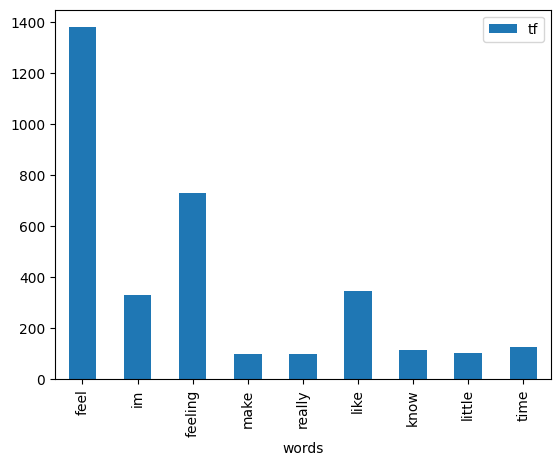

In [20]:
# Barplot grafiğini oluşturunuz.

# Sütunların isimlendirilmesi
tf.columns = ["words", "tf"]
# 100'den fazla geçen kelimelerin görselleştirilmesi
tf[tf["tf"] > 100].plot.bar(x="words", y="tf")
plt.show()

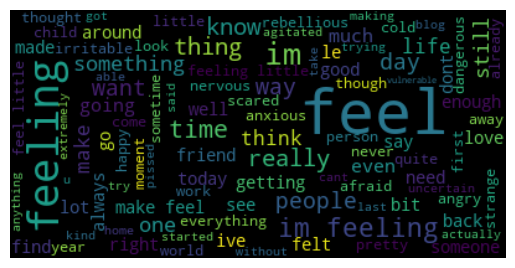

In [21]:
# Kelimeleri WordCloud ile görselleştiriniz.

# kelimeleri birleştirdik
text = " ".join(i for i in df["text"])

# wordcloud görselleştirmenin özelliklerini belirliyoruz
wordcloud = WordCloud(max_font_size=50,
max_words=100,
background_color="black").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Makine öğrenimi

In [22]:
# Train-Test
x_train, x_test, y_train, y_test = train_test_split(df["text"],df["Emotion"], test_size = 0.20,random_state=42,stratify = df['Emotion'])

In [23]:
# Makine öğrenmesi modeline verileri verebilmemiz için temsil şekillerini sayısala çevirmemiz gerekmekte.

# CountVectorizer kullanarak
count_vec = CountVectorizer()
x_train = count_vec.fit_transform(x_train)
x_test = count_vec.transform(x_test)

In [24]:
# modeli kurarak train dataları ile fit ediniz.

model = RandomForestClassifier() 
model_fit = model.fit(x_train, y_train)

In [25]:
# Test verilerini kullanarak tahmin yapın
y_pred = model_fit.predict(x_test)

In [26]:
def sınıflandırma_raporu( y_test, y_pred):
    
    mse = mean_squared_error(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    
    clf = classification_report(y_test, y_pred)
    
    print('MSE: {0:.5f}'.format(mse))
    print('f1_score: {0:.3f}'.format(f1))
    print('accuracy_score: {0:.3f}'.format(acc))
    print('\n',clf)

In [27]:
y_pred_dense = y_pred.toarray() if hasattr(y_pred, "toarray") else y_pred
y_test_dense = y_test.toarray() if hasattr(y_test, "toarray") else y_test
sınıflandırma_raporu(y_test_dense, y_pred_dense)

MSE :0.87750
f1_score :0.942
accuracy_score :0.950

               precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.00      0.00      0.00         1
           2       0.83      1.00      0.91         5
           3       1.00      0.67      0.80         3
           4       0.90      0.82      0.86        11
           5       0.91      1.00      0.95        10
           6       1.00      0.64      0.78        11
           7       0.95      1.00      0.98       333
           8       1.00      0.44      0.62         9
           9       1.00      0.50      0.67         4
          10       0.00      0.00      0.00         1
          11       1.00      0.33      0.50         3

    accuracy                           0.95       400
   macro avg       0.79      0.60      0.66       400
weighted avg       0.95      0.95      0.94       400




 Confusion Matrix: 



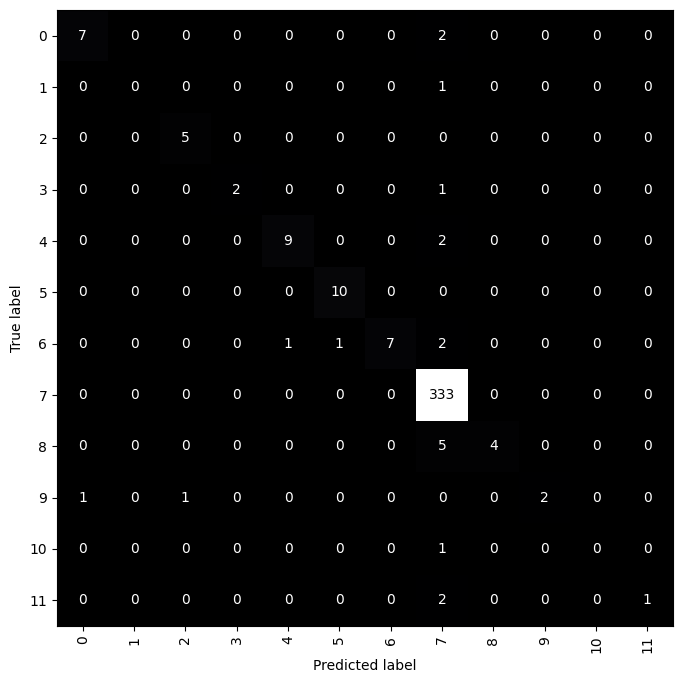

In [28]:
def confusionmatrix( y_test, y_pred):

    print('\n Confusion Matrix: \n')

    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm)
    fig, axs = plt.subplots(figsize=(8, 8))
    cmd.plot(ax=axs, cmap='bone', xticks_rotation="vertical", colorbar=False)

y_pred_dense = y_pred.toarray() if hasattr(y_pred, "toarray") else y_pred
y_test_dense = y_test.toarray() if hasattr(y_test, "toarray") else y_test
confusionmatrix(y_test_dense, y_pred_dense)

In [29]:
# Çapraz doğrulama skorunu hesaplayın ve yazdırın
cross_val_mean = cross_val_score(model, x_test, y_test, cv=5, n_jobs=-1).mean()
print("Cross-Validation Score:", cross_val_mean)

Cross-Validation Score: 0.835
